# Training a Binary Classifier

In [11]:
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Where to save the figures
PROJECT_ROOT_DIR = "."
NOTEBOOK_NAME = "binary-classifier"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", NOTEBOOK_NAME)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
# fetch the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Let's look at the data shape.



In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
28 * 28

784

The above shows that there are 70,000 images and that each picture has 784 features. The reason for this is that each image is 28x28 pixels. Each feature represents one pixel's intensity from 0 (white) to 255 (black).

In [32]:
X.dtype

dtype('float64')

In [38]:
dt = y.dtype
dt

dtype('O')

In [39]:
dt.itemsize

8

In [40]:
dt.name

'object'

In [17]:
print(*[[feature for feature in mnist.feature_names][:10],[feature for feature in mnist.feature_names][-10:]])

['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10'] ['pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780', 'pixel781', 'pixel782', 'pixel783', 'pixel784']


In [31]:
import pandas as pd
pd.DataFrame(mnist.data[0:1], columns=mnist.feature_names)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[['0' 6903]
 ['1' 7877]
 ['2' 6990]
 ['3' 7141]
 ['4' 6824]
 ['5' 6313]
 ['6' 6876]
 ['7' 7293]
 ['8' 6825]
 ['9' 6958]]


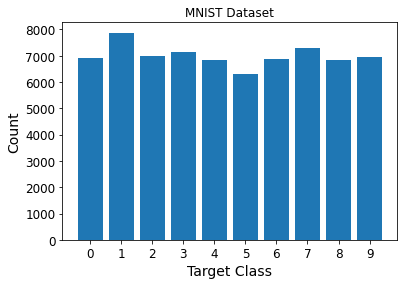

In [57]:
import numpy as np
unique, counts = np.unique(y, return_counts=True)
print(np.c_[unique, counts])
plt.bar(unique, counts)
plt.title('MNIST Dataset')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()

Let's print one of the digits.

Saving figure some_digit_plot


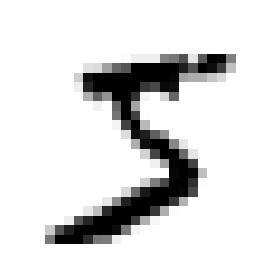

In [58]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [59]:
y[0]

'5'

In [74]:
y = y.astype(np.uint8)

Let's look at some more images from the dataset.

In [60]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


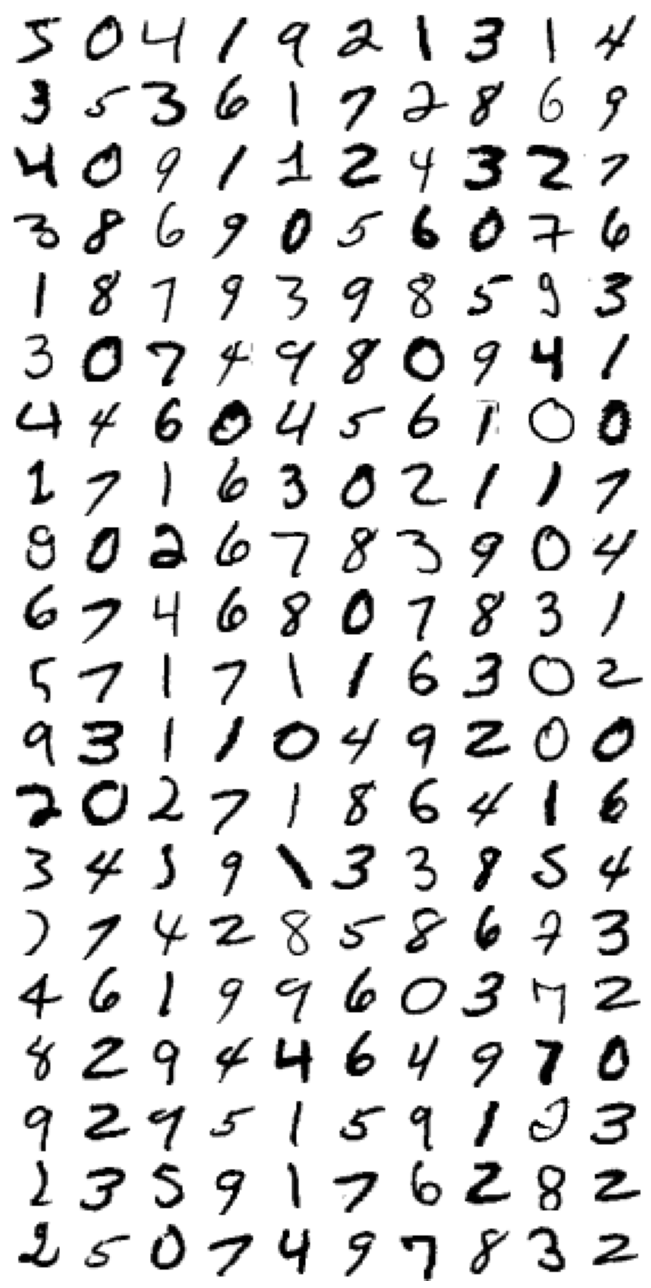

In [66]:
plt.figure(figsize=(18,18))
example_images = X[0:200]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

The MNIST dataset is split into a training (the first 60,000 images) and a test set (the last 10,000 images). 

In [76]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Next, we shuffle the training set, guaranteeing that all cross-validation folds are similar and not missing any digits. Also, some algorithms are sensitive to the order of training instances. However, shuffling is bad when working on time-series data, such as stock market prices and weather conditions.

In [77]:
np.random.seed(42)
shuffle_index = np.random.permutation(60000)
shuffle_index

array([12628, 37730, 39991, ...,   860, 15795, 56422])

In [78]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Let's simplify the problem and only try to identify the number five, an example of a *binary classifier*. Binary classifiers distinguish between just two classes. In this instance, five and not five. We need to create target vectors for the classification task:

In [84]:
y_train_5 = (y_train == 5)
np.nonzero(y_train_5)


(array([    8,    11,    25, ..., 59928, 59942, 59965], dtype=int64),)

In [83]:
y_test_5 = (y_test == 5)
np.nonzero(y_test_5)


(array([   8,   15,   23,   45,   52,   53,   59,  102,  120,  127,  129,
         132,  152,  153,  155,  162,  165,  167,  182,  187,  207,  211,
         218,  219,  240,  253,  261,  283,  289,  317,  319,  333,  340,
         347,  351,  352,  356,  364,  367,  375,  395,  397,  406,  412,
         433,  460,  469,  478,  483,  491,  502,  509,  518,  540,  570,
         588,  604,  618,  638,  645,  654,  674,  692,  694,  710,  711,
         720,  739,  751,  766,  778,  779,  785,  791,  797,  812,  856,
         857,  866,  869,  897,  934,  935,  951,  955,  970,  978, 1003,
        1022, 1032, 1041, 1046, 1070, 1073, 1082, 1087, 1089, 1102, 1113,
        1115, 1131, 1135, 1144, 1146, 1168, 1169, 1190, 1221, 1233, 1235,
        1243, 1252, 1258, 1272, 1281, 1285, 1289, 1299, 1331, 1334, 1339,
        1340, 1370, 1376, 1378, 1393, 1405, 1406, 1421, 1447, 1460, 1466,
        1467, 1471, 1473, 1476, 1493, 1510, 1521, 1525, 1550, 1598, 1618,
        1629, 1635, 1637, 1639, 1641, 

Now we can pick a classifier and train it. *Stochastic Gradient Descent* (SGD) is a good place to start. The classifier can handle very large datasets efficiently since it deals with training instances independently, one at a time, making SGD well suited for _online learning_. Let's create an `SGDClassifier` and train it on the whole training set.

In [88]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now you can use the classifier to detect images of the number 5:

In [89]:
sgd_clf.predict([some_digit])

array([ True])

In this case, the classifier guesses correct. The image represents a 5. Next, we want to evaluate the model's performance.